## Instalasi Library

Sebelum memulai pemodelan, perlu dilakukan instalasi pustaka eksternal yang tidak tersedia secara default di lingkungan Colaboratory Notebook. Pustaka scikit-surprise digunakan dalam proyek ini untuk membangun sistem rekomendasi berbasis collaborative filtering.

In [ ]:
# install library kebutuhan
!pip install scikit-surprise

## Import Library
Langkah selanjutnya adalah mengimpor seluruh library yang dibutuhkan dalam proses eksplorasi data, pemrosesan teks, serta pembangunan dan evaluasi model sistem rekomendasi.
- `pandas`, `numpy`: Untuk manipulasi dan analisis data tabular.
- `matplotlib`, `seaborn`: Untuk visualisasi data.
- `TfidfVectorizer`, `cosine_similarity`: Untuk membangun model content-based filtering berbasis teks.
- `surprise`: Library khusus untuk membangun dan mengevaluasi sistem rekomendasi berbasis collaborative filtering.
- `defaultdict`: Untuk menyusun struktur data dictionary dengan default nilai.

In [2]:
# IMPORT LIBRARY
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import Counter
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
from collections import defaultdict

In [2]:
# Mount Google Drive untuk mengakses dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Membaca dataset anime dari Google Drive dan menampilkannya
anime = pd.read_csv('/content/drive/MyDrive/ML dicoding/machine learning terapan/rekomendasi/submission/anime.csv')
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [3]:
# Membaca dataset arting dari Google Drive dan menampilkannya
rating = pd.read_csv('/content/drive/MyDrive/ML dicoding/machine learning terapan/rekomendasi/submission/rating.csv')
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


## Meninjau Struktur Dataset
Sebelum melakukan pra-pemrosesan, perlu dilihat struktur umum dataset untuk mengetahui jumlah fitur, tipe data pada masing-masing kolom, dan apakah ada nilai yang hilang (missing values) menggunakan metode `info()`.

In [5]:
# Lihat sekilas data
print("Struktur data anime: ")
anime.info()
print("\n==================================================================")
print("Struktur data rating: ")
rating.info()

Struktur data anime: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

Struktur data rating: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## Melihat Statistik Deskriptif Dataset
Langkah ini bertujuan untuk memahami distribusi data pada setiap kolom, termasuk nilai minimum, maksimum, rata-rata, serta jumlah nilai unik untuk data kategorikal. Metode `describe()` dengan parameter `include='all'` digunakan agar semua tipe data tercakup dalam ringkasan statistik ini. Informasi ini penting untuk tahap eksplorasi data awal dan proses pembersihan data.

In [ ]:
# lihat deskripsi statistik
anime.describe(include='all')

,anime_id,name,genre,type,episodes,rating,members
count,12294.000000,12294,12232,12269,12294,12064.000000,1.229400e+04
unique,NaN,12292,3264,6,187,NaN,NaN
top,NaN,Saru Kani Gassen,Hentai,TV,1,NaN,NaN
freq,NaN,2,823,3787,5677,NaN,NaN
mean,14058.221653,NaN,NaN,NaN,NaN,6.473902,1.807134e+04
std,11455.294701,NaN,NaN,NaN,NaN,1.026746,5.482068e+04
min,1.000000,NaN,NaN,NaN,NaN,1.670000,5.000000e+00
25%,3484.250000,NaN,NaN,NaN,NaN,5.880000,2.250000e+02
50%,10260.500000,NaN,NaN,NaN,NaN,6.570000,1.550000e+03
75%,24794.500000,NaN,NaN,NaN,NaN,7.180000,9.437000e+03


In [ ]:
# analisis statistik deskriptif data rating
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


## Melihat Daftar Nilai Unik pada Beberapa Kolom
Pada tahap ini, kita menampilkan nilai-nilai unik dari beberapa kolom penting seperti `name`, `genre`, `type`, dan `episodes`. Tujuannya adalah untuk memahami variasi data pada tiap kolom serta mendeteksi kemungkinan anomali atau inkonsistensi yang perlu ditangani pada tahap pembersihan data.

In [ ]:
# tampilkan list data unik dari kolom name, genre, type, episodes, rating
print('Unique names:', anime['name'].unique())
print("==================================================================")
print('Unique genres:', anime['genre'].unique())
print("==================================================================")
print('Unique episodes:', anime['episodes'].unique())

Unique names: ['Kimi no Na wa.' 'Fullmetal Alchemist: Brotherhood' 'Gintama°' ...
 'Violence Gekiga David no Hoshi'
 'Violence Gekiga Shin David no Hoshi: Inma Densetsu'
 'Yasuji no Pornorama: Yacchimae!!']
Unique genres: ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen' ...
 'Hentai, Sports' 'Drama, Romance, School, Yuri' 'Hentai, Slice of Life']
Unique episodes: ['1' '64' '51' '24' '10' '148' '110' '13' '201' '25' '22' '75' '4' '26'
 '12' '27' '43' '74' '37' '2' '11' '99' 'Unknown' '39' '101' '47' '50'
 '62' '33' '112' '23' '3' '94' '6' '8' '14' '7' '40' '15' '203' '77' '291'
 '120' '102' '96' '38' '79' '175' '103' '70' '153' '45' '5' '21' '63' '52'
 '28' '145' '36' '69' '60' '178' '114' '35' '61' '34' '109' '20' '9' '49'
 '366' '97' '48' '78' '358' '155' '104' '113' '54' '167' '161' '42' '142'
 '31' '373' '220' '46' '195' '17' '1787' '73' '147' '127' '16' '19' '98'
 '

## Pengecekan Missing Value
Pada langkah ini, kita memeriksa apakah ada nilai yang hilang (missing values) pada setiap kolom dataset dengan menggunakan fungsi `isnull()` yang dikombinasikan dengan `sum()`. Fungsi ini menghitung jumlah nilai NaN (Not a Number) pada setiap kolom, sehingga kita dapat mengetahui kolom mana saja yang perlu penanganan khusus sebelum analisis dan pemodelan.

In [ ]:
# Cek missing value pada kolom genre
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [ ]:
# Cek missing values
rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


## Pengecekan Data Duplikat
Langkah ini bertujuan untuk memastikan apakah terdapat baris data yang duplikat di dataset anime. Data duplikat dapat terjadi ketika ada entri yang sama persis, yang bisa mengakibatkan hasil analisis menjadi bias. Oleh karena itu, kita perlu memeriksa dan mengetahui jumlah data yang duplikat agar dapat mengambil tindakan selanjutnya seperti menghapusnya.

Cara pengecekannya yaitu dengan menggunakan method `duplicated()` pada DataFrame yang akan menghasilkan Boolean untuk tiap baris apakah itu duplikat atau tidak. Selanjutnya, kita jumlahkan semua nilai True dengan `sum()` untuk mengetahui berapa banyak data yang benar-benar duplikat.

In [ ]:
# cek duplikat
print("Jumlah data duplikat pada dataset anime:", anime.duplicated().sum())
print("Jumlah data duplikat pada dataset rating:", rating.duplicated().sum())

Jumlah data duplikat pada dataset anime: 0
Jumlah data duplikat pada dataset rating: 1


## Visualisasi Genre Anime Terpopuler
Langkah ini bertujuan untuk mengetahui genre anime yang paling sering muncul dalam dataset. Karena satu anime bisa memiliki lebih dari satu genre yang dipisahkan dengan koma, maka kita perlu memisahkan setiap genre tersebut terlebih dahulu.

Caranya adalah:
- Memisahkan string genre menjadi list genre menggunakan fungsi `.split(', ')`.
- Menggabungkan semua genre dari seluruh anime menjadi satu list datar (flat_genres).
- Menghitung frekuensi kemunculan setiap genre menggunakan Counter.
- Mengambil 15 genre teratas berdasarkan jumlah kemunculan.
- Membuat visualisasi batang horizontal (barh) untuk memperlihatkan popularitas genre tersebut.

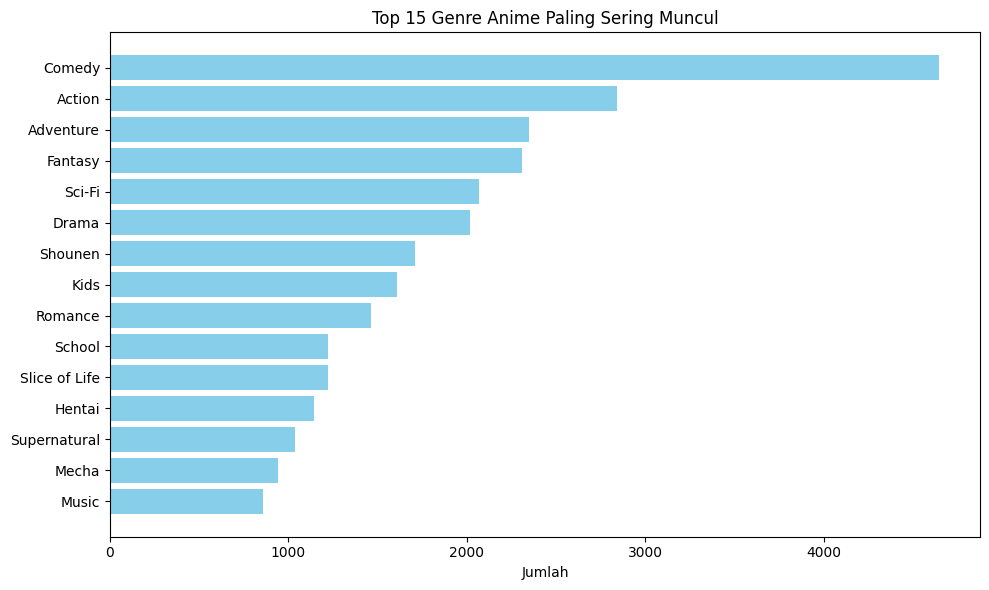

In [ ]:
# Pisah semua genre
all_genres = anime['genre'].dropna().apply(lambda x: x.split(', '))
flat_genres = [g for sublist in all_genres for g in sublist]

# Hitung frekuensi
genre_counts = Counter(flat_genres)

# Ambil Top-N (misalnya 15 besar)
top_genres = genre_counts.most_common(15)
labels, values = zip(*top_genres)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.title('Top 15 Genre Anime Paling Sering Muncul')
plt.xlabel('Jumlah')
plt.gca().invert_yaxis()  # Biar ranking dari atas ke bawah
plt.tight_layout()
plt.show()

## Visualisasi Distribusi Rating Anime
Langkah ini bertujuan untuk memahami bagaimana distribusi nilai rating yang diberikan oleh pengguna pada berbagai anime. Dengan memanfaatkan fungsi `value_counts()` dan `sort_index()`, dihitung jumlah kemunculan masing-masing nilai rating. Kemudian, digunakan seaborn.barplot untuk memvisualisasikan distribusi tersebut dalam bentuk grafik batang.

Visualisasi ini dapat memberikan wawasan apakah terdapat kecenderungan rating tinggi atau rendah dalam dataset, serta apakah data rating cenderung seimbang atau tidak.

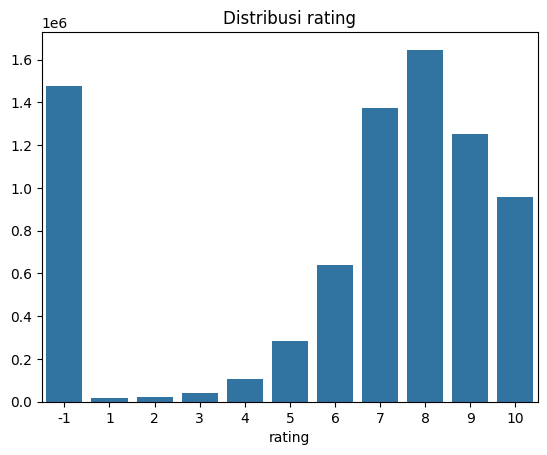

In [ ]:
# Hitung jumlah kemunculan setiap nilai rating (frekuensi) dan urutkan berdasarkan nilai rating
rating_count = rating['rating'].value_counts().sort_index()

# Visualisasikan distribusi rating menggunakan barplot dari Seaborn
sns.barplot(x=rating_count.index, y=rating_count.values).set_title('Distribusi rating');

# CONTENT BASE FILTERING

## Menstandarkan Format Genre
Langkah ini dilakukan untuk menstandarkan format teks pada kolom genre, dilakukan penggantian karakter strip (-) menjadi underscore (_). Hal ini bertujuan agar kolom `genre` yang terdiri dari dua kata seperti `sci-fi` tidak dipisahkan saat diproses oleh algoritma ekstraksi fitur TF-IDF. Proses ini dilakukan dengan metode `str.replace()` pada seluruh entri di kolom `genre`. Dengan begitu, genre-genre tersebut tetap dikenali sebagai satu token yang utuh dalam proses tokenisasi.  

In [ ]:
# Ganti '-' jadi '_', supaya genre yang punya strip dianggap satu token
anime['genre'] = anime['genre'].str.replace('-', '_')

In [ ]:
# menampilkan dataset anime
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci_Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


## Pembersihan Data: Penanganan Missing Value dan Nilai Tidak Valid
Karena pendekatan content-based filtering dalam proyek ini hanya menggunakan informasi dari kolom `genre`, namun pembersihan dilakukan pada semua kolom untuk memastikan integritas data secara keseluruhan.

Pertama, nilai kosong pada kolom `genre` diganti dengan string kosong ('') agar tidak menyebabkan error saat proses pemrosesan teks. Selanjutnya, baris yang masih memiliki nilai kosong pada kolom `genre` dan `type` dihapus menggunakan `dropna()`, karena informasi ini esensial untuk proses rekomendasi.

Untuk kolom `rating`, nilai kosong diisi dengan nilai rata-rata dari seluruh rating menggunakan `fillna()`, guna mempertahankan data sebanyak mungkin tanpa mengabaikan kualitas.

Baris pada kolom `episodes` yang memiliki nilai 'Unknown' yang terlihat pada pengecekan nilai unik sebelumnya, pada proyek ini dihapus karena nilai tersebut tidak valid.

In [ ]:
# menghapus kolom genre dan type yang missing value
# Ganti nilai genre yang kosong (NaN) dengan string kosong
anime['genre'] = anime['genre'].fillna('')
# Apply the filters directly to the 'anime' DataFrame
anime = anime.dropna(subset=['genre', 'type']).reset_index(drop=True)

# ganti kolom rating yang missing value dengan mean
anime['rating'] = anime['rating'].fillna(anime['rating'].mean())

# kolom episodes yang bernilai unkown dihapus
anime = anime[anime['episodes'] != 'Unknown']

In [ ]:
anime.shape

(11954, 7)

## Konversi Tipe Data Kolom episodes
Kolom episodes secara default dibaca sebagai tipe data objek (string), padahal secara semantik nilainya bersifat numerik. Itu dikarenakan sebelumnya terdapat nilai yang berisi `Unknown` sehingga bertipe data objek. Oleh karena itu, dilakukan konversi tipe data ke dalam bentuk integer. Proses ini penting untuk memastikan data mempunyai data yang berkualitas.

In [ ]:
# Ubah kolom episodes dari string ke integer
anime['episodes'] = anime['episodes'].astype(int)

## Penerapan TF-IDF pada Fitur Genre
Langkah ini bertujuan untuk mengubah data teks pada kolom genre menjadi representasi numerik menggunakan teknik TF-IDF (Term Frequency–Inverse Document Frequency). Caranya yaitu dengan memanfaatkan `TfidfVectorizer` dari `Scikit-learn` untuk menghitung bobot setiap genre berdasarkan frekuensi kemunculannya di seluruh anime. Stop words bahasa Inggris dihapus untuk menghindari kata-kata umum yang tidak bermakna. Hasil transformasi berupa matriks TF-IDF digunakan untuk mengukur kemiripan antar anime dalam proses content-based filtering.

In [ ]:
# TERAPKAN TF-IDF PADA KOLOM GENRE
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(anime['genre'])
# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(11954, 45)

## Perhitungan Cosine Similarity
Setelah data genre diubah menjadi representasi numerik menggunakan TF-IDF, langkah selanjutnya adalah menghitung `cosine similarity` antar data. Cosine similarity mengukur kemiripan antara dua vektor yang dalam hal ini, representasi TF-IDF dari genre anime berdasarkan sudut antara keduanya. Nilai similarity berkisar antara -1 sampai 1, dimana nilai yang lebih tinggi menunjukkan anime yang lebih mirip. Matriks similarity yang dihasilkan akan digunakan untuk merekomendasikan anime yang serupa berdasarkan genre.
Kode ini menghitung similarity antara semua pasangan anime dalam dataset dan menampilkan bentuk matriks hasil perhitungan tersebut.

In [ ]:
# menghitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Shape of Cosine Similarity matrix:", cosine_sim.shape)
cosine_sim

Shape of Cosine Similarity matrix: (11954, 11954)


array([[1.        , 0.14701722, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14701722, 1.        , 0.18599594, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.18599594, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

## Mapping Nama Anime ke Indeks DataFrame
Untuk memudahkan pencarian dan pengambilan data anime berdasarkan nama, langkah ini membuat sebuah mapping antara nama anime dengan indeks barisnya pada DataFrame. Dengan cara ini, ketika pengguna memasukkan judul anime, sistem bisa langsung menemukan posisi anime tersebut dalam dataset secara efisien. Pastikan nama anime bersifat unik agar mapping ini tidak menimbulkan duplikasi.
Kode drop_duplicates() digunakan untuk memastikan tidak ada nama anime yang sama pada indeks tersebut.

In [ ]:
# Mapping nama anime ke indeks dataframe pada dataframe yang sudah difilter
# Pastikan semua nama unik dan ada dalam index
anime = anime.reset_index(drop=True)
indices = pd.Series(anime.index, index=anime['name']).drop_duplicates()

In [ ]:
# melihat jumlah baris dan kolom
anime.shape

(11954, 7)

## Fungsi Rekomendasi Content-Based Filtering untuk Memberikan Anime Serupa Berdasarkan Genre
Fungsi ini menerima input judul anime dan mengembalikan daftar rekomendasi anime lain yang paling mirip berdasarkan kesamaan konten (genre) menggunakan matriks cosine similarity.
- Pertama, fungsi mengecek apakah judul anime yang diminta ada dalam dataset.
- Jika tidak ditemukan, fungsi mengembalikan pesan error.
- Jika ditemukan, fungsi mengambil indeks anime tersebut lalu mengambil skor similarity antara anime input dengan semua anime lain.
- Skor similarity diurutkan dari yang tertinggi ke terendah.
- Rekomendasi diambil dari anime dengan similarity tertinggi, dengan mengabaikan anime input itu sendiri.
- Fungsi mengembalikan daftar nama anime hasil rekomendasi sebanyak top_n.

Pendekatan ini memanfaatkan kemiripan genre antar anime untuk memberikan rekomendasi yang relevan.

In [ ]:
# Fungsi rekomendasi content-based filtering (exclude anime input sendiri)
def content_based_recommendation(title, top_n=10):
    if title not in indices:
        return f"Anime '{title}' tidak ditemukan."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # exclude anime itu sendiri

    anime_indices = [i[0] for i in sim_scores]
    recommendations = anime['name'].iloc[anime_indices].tolist()
    return recommendations

## Evaluasi Presisi pada Sistem Rekomendasi Content-Based Filtering
Fungsi `precision_at_k_cbf` digunakan untuk mengukur precision dari rekomendasi yang dihasilkan oleh sistem content-based filtering. Precision di sini mengukur seberapa relevan rekomendasi yang diberikan, berdasarkan kesamaan genre antara anime input dengan anime yang direkomendasikan.

Prosesnya adalah sebagai berikut:
- Pertama, fungsi mengambil indeks anime yang menjadi input berdasarkan judul.
- Selanjutnya, genre dari anime input diubah menjadi himpunan (set) untuk memudahkan perbandingan.
- Fungsi kemudian memanggil content_based_recommendation untuk mendapatkan daftar anime yang direkomendasikan.
- Setelah itu, fungsi menghitung berapa banyak anime rekomendasi yang memiliki minimal satu genre yang sama dengan anime input.
- Terakhir, precision dihitung sebagai rasio jumlah rekomendasi relevan dibandingkan dengan total rekomendasi yang diminta (top_n).

In [ ]:
def precision_at_k_cbf(title, top_n=10):
    # Ambil indeks anime dari judul, jika tidak ada kembalikan None
    idx = indices.get(title, None)
    if idx is None:
        return None

    # Ubah genre anime input menjadi set untuk perbandingan mudah
    input_genre = set(anime.loc[idx, 'genre'].split(', '))

    # Dapatkan daftar rekomendasi dari fungsi content-based filtering
    recs = content_based_recommendation(title, top_n=top_n)

    # Hitung jumlah rekomendasi yang genre-nya setidaknya satu sama dengan input
    relevant = 0
    for rec in recs:
        rec_idx = indices.get(rec)
        rec_genre = set(anime.loc[rec_idx, 'genre'].split(', '))
        if len(input_genre.intersection(rec_genre)) > 0:
            relevant += 1

    # Precision = rekomendasi relevan dibagi total rekomendasi
    precision = relevant / top_n
    return precision

## Prediksi Rekomendasi dan Evaluasi Presisi
Pada bagian ini, dilakukan proses prediksi rekomendasi anime menggunakan metode content-based filtering berdasarkan judul anime input, yaitu 'Under World'. Fungsi `content_based_recommendation` akan mengembalikan daftar 10 anime yang paling mirip berdasarkan genre.

Selanjutnya, evaluasi dilakukan dengan menghitung nilai presisi (precision) menggunakan fungsi `precision_at_k_cbf`, yang mengukur proporsi rekomendasi yang memiliki genre yang sama dengan anime input. Nilai presisi ini memberikan gambaran seberapa relevan hasil rekomendasi yang diberikan sistem.

In [ ]:
# PREDIKSI DAN EVALUASI
query = 'Under World'
print(f"Rekomendasi Content-Based untuk '{query}':")
recommendations = content_based_recommendation(query, top_n=10)
for i, title in enumerate(recommendations, 1):
    print(f"{i}. {title}")

precision = precision_at_k_cbf(query, top_n=10)
print(f"\nPrecision: {precision:.2f}")

Rekomendasi Content-Based untuk 'Under World':
1. Mankitsu Happening
2. Koiito Kinenbi The Animation
3. Oni Chichi: Rebuild
4. Eroge! H mo Game mo Kaihatsu Zanmai
5. Oni Chichi: Re-birth
6. Swing Out Sisters (2014)
7. Maki-chan to Nau.
8. Stringendo: Angel-tachi no Private Lesson
9. Shoujo Ramune
10. Fella Pure: Mitarashi-san Chi no Jijou The Animation

Precision: 1.00


# COLABORATIVE FILTERING

### Menghapus kolom `rating` yang bernilai -1
Dalam dataset rating, terdapat nilai -1 yang merepresentasikan bahwa pengguna belum memberikan rating sebenarnya terhadap suatu anime. Data semacam ini dapat mengganggu proses pelatihan model karena tidak mencerminkan preferensi pengguna yang valid. Oleh karena itu, nilai rating -1 dihapus agar hanya data dengan rating eksplisit yang digunakan dalam sistem rekomendasi.

In [4]:
# Hapus rating = -1 (artinya user belum ngasih rating)
rating = rating[rating['rating'] != -1]

In [5]:
rating.shape

(6337241, 3)

## Menghapus Duplikasi Data Rating
Sebelum membangun model rekomendasi berbasis collaborative filtering, penting untuk memastikan bahwa setiap entri data unik. Adanya duplikasi misalnya pengguna memberikan rating yang sama untuk anime yang sama lebih dari satu kali, itu dapat memengaruhi hasil pelatihan model. Oleh karena itu, dilakukan penghapusan baris duplikat pada dataset rating untuk menjaga integritas data.

In [6]:
# hapus data duplikat pada data rating
rating = rating.drop_duplicates()

## Menyiapkan Data untuk Library Surprise
Untuk membangun model collaborative filtering, digunakan library Surprise yang memerlukan format data tertentu. Oleh karena itu, dilakukan proses persiapan data dengan memanfaatkan Reader dari Surprise untuk mendefinisikan skala rating (dalam hal ini dari 1 hingga 10). Selanjutnya, dataset rating dikonversi ke format internal Surprise menggunakan `Dataset.load_from_df()` agar dapat digunakan dalam proses pelatihan model rekomendasi.

In [8]:
# Definisikan skala rating yang digunakan (1 hingga 10)
reader = Reader(rating_scale=(1, 10))

# Konversi dataframe rating ke format Surprise (user_id, anime_id, rating)
data = Dataset.load_from_df(rating[['user_id', 'anime_id', 'rating']], reader)

## Membagi Data untuk Pelatihan dan Pengujian Model
Langkah ini bertujuan untuk memisahkan data ke dalam dua bagian: data pelatihan (trainset) dan data pengujian (testset) menggunakan fungsi train_test_split dari Surprise. Proporsi data uji ditentukan sebesar 20%. Pembagian ini penting agar model dapat diuji pada data yang belum pernah dilihat sebelumnya, untuk mengukur performa secara objektif. Setelah pembagian, jumlah rating pada masing-masing subset ditampilkan sebagai verifikasi.

In [9]:
# split data
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Gunakan trainset.n_ratings untuk mendapatkan jumlah rating di trainset
print(f"Jumlah data train: {trainset.n_ratings}")
print(f"Jumlah data test: {len(testset)}")

Jumlah data train: 5069792
Jumlah data test: 1267448


## Melatih dan Memprediksi Model Collaborative Filtering
Pada tahap ini, model SVD (Singular Value Decomposition) digunakan sebagai algoritma collaborative filtering berbasis matrix factorization untuk memprediksi rating yang belum diberikan oleh pengguna. Model dilatih menggunakan data pelatihan (trainset), kemudian digunakan untuk melakukan prediksi terhadap data pengujian (testset) agar dapat dievaluasi performanya.

In [ ]:
# Membuat dan melatih model SVD menggunakan data pelatihan
model = SVD()
model.fit(trainset)

# Melakukan prediksi pada data pengujian
predictions = model.test(testset)

## Evaluasi Performa Model Collaborative Filtering
Setelah model SVD dilatih dan melakukan prediksi pada data pengujian, tahap selanjutnya adalah mengevaluasi performanya menggunakan metrik RMSE (Root Mean Squared Error) dan MAE (Mean Absolute Error). Kedua metrik ini mengukur seberapa dekat hasil prediksi terhadap nilai rating sebenarnya, di mana nilai yang lebih kecil menandakan performa yang lebih baik.

In [ ]:
# Menghitung nilai RMSE dan MAE dari hasil prediksi model
rmse_val = rmse(predictions)
mae_val = mae(predictions)

# Menampilkan hasil evaluasi
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE:  {mae_val:.4f}")

RMSE: 1.1326
MAE:  0.8445


## Evaluasi dan Rekomendasi dengan Collaborative Filtering (SVD)
Setelah model SVD selesai dilatih, langkah penting berikutnya adalah mengevaluasi performa model tersebut. Fungsi `precision_recall_at_k` digunakan untuk menghitung dua metrik evaluasi utama yaitu precision dan recall pada top-K rekomendasi yang dihasilkan oleh model. Precision mengukur seberapa banyak rekomendasi yang diberikan oleh model ternyata relevan berdasarkan rating asli pengguna, sementara recall mengukur seberapa banyak rekomendasi relevan yang berhasil ditemukan dari keseluruhan item yang sebenarnya relevan untuk pengguna tersebut. Dalam fungsi ini, prediksi dan rating asli dikelompokkan berdasarkan user, lalu diurutkan berdasarkan estimasi rating tertinggi. Threshold rating 4.0 digunakan untuk menentukan apakah suatu item dianggap relevan atau tidak. Nilai precision dan recall kemudian dihitung untuk setiap pengguna, dan hasil akhirnya adalah rata-rata dari semua pengguna sebagai gambaran performa sistem secara keseluruhan.

Setelah evaluasi, model dapat digunakan untuk memberikan rekomendasi personal kepada pengguna tertentu. Proses ini dimulai dengan memilih `user_id` target yang ingin diberikan rekomendasi. Selanjutnya, daftar anime yang sudah pernah diberi rating oleh user tersebut diidentifikasi, dan kemudian anime yang belum pernah dinilai oleh user tersebut difilter sebagai kandidat rekomendasi. Model SVD kemudian memprediksi rating untuk setiap anime dalam daftar kandidat tersebut. Dari hasil prediksi ini, diambil 10 anime dengan prediksi rating tertinggi sebagai rekomendasi terbaik untuk pengguna. Rekomendasi tersebut kemudian digabungkan dengan data asli anime agar nama anime dapat ditampilkan bersama nilai prediksi ratingnya. Akhirnya, daftar rekomendasi untuk user tersebut ditampilkan dalam format yang mudah dipahami.

Kode ini tidak hanya melakukan evaluasi kinerja model berdasarkan data test, tetapi juga memberikan contoh nyata bagaimana model dapat dimanfaatkan untuk memberikan rekomendasi yang dipersonalisasi, sehingga memperlihatkan kegunaan praktis dari sistem rekomendasi berbasis Collaborative Filtering yang dibangun menggunakan algoritma SVD.

In [ ]:
# Mengambil 10 anime terbaik berdasarkan estimasi rating tertinggi dari prediksi
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Urutkan setiap daftar berdasarkan estimasi rating, dan ambil top-n
    for uid, user_rating in top_n.items():
        user_rating.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_rating[:n]
    return top_n

# Menghitung precision dan recall pada top-k rekomendasi
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = dict(), dict()

    for uid, user_rating in user_est_true.items():
        user_rating.sort(key=lambda x: x[0], reverse=True)
        top_k = user_rating[:k]

        # Hitung jumlah relevan dan rekomendasi relevan
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_rating)
        n_rec_k = sum((est >= threshold) for (est, _) in top_k)
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in top_k)

        precisions[uid] = n_rel_and_rec_k / k if k else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel else 0

    # Hitung rata-rata dari semua pengguna
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

    return avg_precision, avg_recall

# Evaluasi precision dan recall dari model collaborative filtering
precision, recall = precision_recall_at_k(predictions, k=10, threshold=4.0)
print(f"\n Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")

# REKOMENDASI UNTUK USER TERTENTU
target_user_id = 40115

# Dapatkan daftar anime yang belum diberi rating oleh user
rated_anime_ids = rating[rating['user_id'] == target_user_id]['anime_id'].tolist()
all_anime_ids = anime['anime_id'].unique()
unrated_anime_ids = list(set(all_anime_ids) - set(rated_anime_ids))

# Prediksi rating untuk semua anime yang belum ditonton
predictions_user = []
for aid in unrated_anime_ids:
    pred = model.predict(uid=target_user_id, iid=aid)
    predictions_user.append((aid, pred.est))

# Ambil 10 anime dengan prediksi rating tertinggi
top_10 = sorted(predictions_user, key=lambda x: x[1], reverse=True)[:10]

# Gabungkan dengan nama anime
top_10_df = pd.DataFrame(top_10, columns=['anime_id', 'predicted_rating'])
top_10_df = pd.merge(top_10_df, anime[['anime_id', 'name']], on='anime_id')

# Tampilkan hasil rekomendasi
print(f"\n Rekomendasi untuk user {target_user_id}:")
for index, row in top_10_df.iterrows():
    print(f"- {row['name']} (ID {row['anime_id']}): {row['predicted_rating']:.2f}")


 Precision: 0.7199
 Recall: 0.7132

 Rekomendasi untuk user 40115:
- Ginga Eiyuu Densetsu (ID 820): 9.94
- Death Note (ID 1535): 9.91
- Code Geass: Hangyaku no Lelouch (ID 1575): 9.77
- Code Geass: Hangyaku no Lelouch R2 (ID 2904): 9.76
- Sakamichi no Apollon (ID 12531): 9.64
- Hellsing Ultimate (ID 777): 9.62
- Cowboy Bebop (ID 1): 9.55
- Clannad: After Story (ID 4181): 9.54
- Fullmetal Alchemist: Brotherhood (ID 5114): 9.52
- Gankutsuou (ID 239): 9.51
